### Libraries

In [6]:
import pandas as pd
import nltk
import preprocessor as p
import re
from gensim.parsing.preprocessing import remove_stopwords
import little_mallet_wrapper
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
pd.options.display.max_colwidth = 100


import pandas as pd
import gensim
from gensim import corpora
from gensim.models import LdaModel
from nltk.stem import SnowballStemmer
from gensim.parsing.preprocessing import STOPWORDS
import re
from nltk.stem import WordNetLemmatizer
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis
import pickle
import matplotlib.pyplot as plt
from gensim.models import CoherenceModel



import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder

### Dataset

In [8]:
df = pd.read_csv("full-corpus-training.csv")
df.head()

,Sentiment,TweetId,TweetText
0,positive,1.260000e+17,Now all @Apple has to do is get swype on the iphone and it will be crack. Iphone that is
1,positive,1.260000e+17,@Apple will be adding more carrier support to the iPhone 4S (just announced)
2,positive,1.260000e+17,Hilarious @youtube video - guy does a duet with @apple 's Siri. Pretty much sums up the love aff...
3,positive,1.260000e+17,@RIM you made it too easy for me to switch to @Apple iPhone. See ya!
4,positive,1.260000e+17,I just realized that the reason I got into twitter was ios5 thanks @apple


### Missing Values

In [3]:
df.isna().sum()

Sentiment    0
TweetId      0
TweetText    0
dtype: int64

### Preprocess the text to remove any stop words or punctuations

In [4]:
stemmer = SnowballStemmer("english")

def clean_text(text):
    # deleting the special charcters
    text = re.sub(r"[^a-zA-Z0-9']", ' ', text)
    # white space normalization
    text = re.sub(r'\s+', ' ', text)
    # apostroph correction
    text = re.sub(r"â€™", "'", text)
    text = re.sub(r"â€œ|â€ ", '"', text)
    text = re.sub(r"â€”", "-", text)
    # lowercase change
    text = text.lower()
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

def cleaning(txt):
    txt = clean_text(txt)
    # remove stopwords, tokenize, lowercase lemmatize
    final = []
    for tok in gensim.utils.simple_preprocess(txt):
        if tok not in gensim.parsing.preprocessing.STOPWORDS and len(tok) > 3:
            final.append(clean_text(tok))
    return final

# cleaning our content column
# combin_all['clean_content'] = combin_all['content'].apply(cleaning)
# combin_all.head()

clean_content = df['TweetText'].map(cleaning)
clean_content.head()

0                                                     [appl, swype, iphon, crack, iphon]
1                                          [appl, add, carrier, support, iphon, announc]
2    [hilari, youtub, video, duet, appl, siri, pretti, sum, love, affair, http, exbnqji]
3                                                            [easi, switch, appl, iphon]
4                                                 [realiz, reason, twitter, thank, appl]
Name: TweetText, dtype: object

In [5]:
# TF IDF vectorizer with adjusted parameters
tfidf_vect = TfidfVectorizer(min_df=5, max_df=0.8)

# Fit and transform
matrix_tfidf = tfidf_vect.fit_transform(clean_content)

# Using get_feature_names_out 
featureNames = tfidf_vect.get_feature_names_out()

# Data frame for our matrix_tfidf and featureNames
df_tfidf = pd.DataFrame(data=matrix_tfidf.toarray(), columns=featureNames)

# Adding up the importance scores (= TF-IDF scores) for every word.
wordScores = df_tfidf.sum(axis=0)

# Sorting words according to how much they matter in all the tweets
# Sorting them with their overall TF-IDF scores.
top50words = wordScores.sort_values(ascending=False).head(50)

# Print top50words
print(top50words)

AttributeError: 'list' object has no attribute 'lower'

In [12]:
def preprocess_tweet(txt):
    text = p.clean(txt)
    return text

df['cleaned_tweets'] = df['TweetText'].apply(preprocess_tweet)

# common words to be removed
common_stopwords = set(['http', 'twitter', 'www', 'like', 'get', 'go', 'lol', 'please'])

def preprocess_tweet_text(tweet):
    # Remove URLs
    tweet = re.sub(r"http\S+|www\S+|https\S+", "", tweet, flags=re.MULTILINE)
    
    # Tokenize the tweet using TweetTokenizer
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
    tokens = tokenizer.tokenize(tweet)
    
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    custom_stopwords = set(['rt', 'via', 'que', 'en', 'es', 'para', 'co', 'con', 'un', 'se', 'las', 'ics', 'los'])
    stop_words.update(custom_stopwords, common_stopwords)
    tokens = [token for token in tokens if token not in stop_words]
    
    tokens = [token for token in tokens if len(token) > 2]

    # Remove punctuations
    tokens = [token for token in tokens if token.isalnum()]
    
    # Join the cleaned tokens together as a string
    processed_tweet = ' '.join(tokens)
    
    return processed_tweet

# Apply the cleaning function to the TweetText column
df['CleanedTweet'] = df['cleaned_tweets'].apply(lambda x: little_mallet_wrapper.process_string(x, numbers='remove'))
df['CleanedTweet'] = df['CleanedTweet'].apply(preprocess_tweet_text)

# TF IDF vectorizer with adjusted parameters
tfidf_vect = TfidfVectorizer(min_df=5, max_df=0.8)

# Fit and transform
matrix_tfidf = tfidf_vect.fit_transform(df['CleanedTweet'])

# Using get_feature_names_out 
featureNames = tfidf_vect.get_feature_names_out()

# Data frame for our matrix_tfidf and featureNames
df_tfidf = pd.DataFrame(data=matrix_tfidf.toarray(), columns=featureNames)

# Adding up the importance scores (= TF-IDF scores) for every word.
wordScores = df_tfidf.sum(axis=0)

# Sorting words according to how much they matter in all the tweets
# Sorting them with their overall TF-IDF scores.
top50words = wordScores.sort_values(ascending=False).head(50)

# Print top50words
print(top50words)


nexus        76.520013
new          75.721955
google       74.835726
sandwich     71.907187
cream        70.888161
android      69.518447
ice          69.295113
galaxy       66.709302
microsoft    63.651374
iphone       61.725037
phone        49.779924
windows      45.086025
ballmer      39.693813
steve        37.951405
por          37.942093
app          33.567207
store        32.940366
samsung      31.352035
use          29.823541
time         29.216693
video        28.740660
siri         28.026507
great        27.736946
love         26.839693
ios          26.261444
one          26.017915
good         25.890755
apple        24.686569
want         23.574323
know         23.422517
people       23.205290
search       23.074015
need         22.659972
back         22.540271
really       22.368526
got          22.024584
del          21.915294
esta         21.893921
update       21.557788
see          20.916745
available    20.210337
thanks       19.322262
ceo          19.307781
facebook   

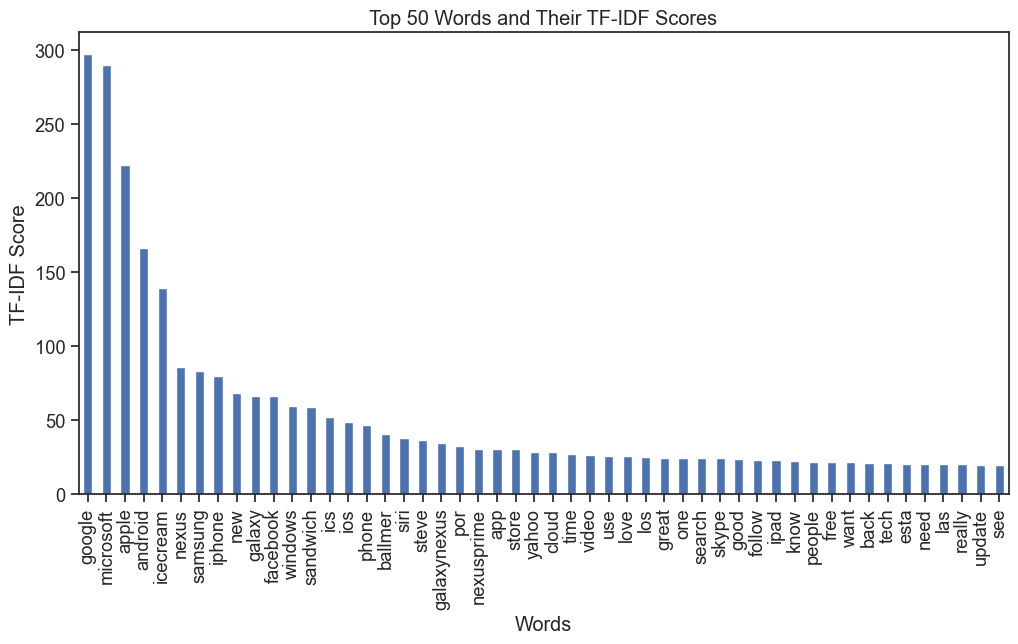

In [6]:

# Visualization of top words
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
top50words.plot(kind='bar')
plt.title('Top 50 Words and Their TF-IDF Scores')
plt.xlabel('Words')
plt.ylabel('TF-IDF Score')
plt.show()



In [5]:
# Display the cleaned DataFrame
print(df[['Sentiment', 'CleanedTweet']].head(10))

  Sentiment  \
0  positive   
1  positive   
2  positive   
3  positive   
4  positive   
5  positive   
6  positive   
7  positive   
8  positive   
9  positive   

                                                                                       CleanedTweet  
0                                                                   apple swype iphone crack iphone  
1                                                     apple adding carrier support iphone announced  
2          hilarious youtube video guy duet apple siri pretty much sums love affair http co exbnqjy  
3                                                             rim made easy switch apple iphone see  
4                                                      realized reason got twitter ios thanks apple  
5                         current blackberry user little bit disappointed move android apple iphone  
6  strangest things siri said far sooo glad apple gave siri sense humor http co twaeudbp happyplace  
7                 